<a href="https://colab.research.google.com/github/egonloch/DNC/blob/main/Desafio_6_Egon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1094]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Target**: Churned

Variáveis do problema

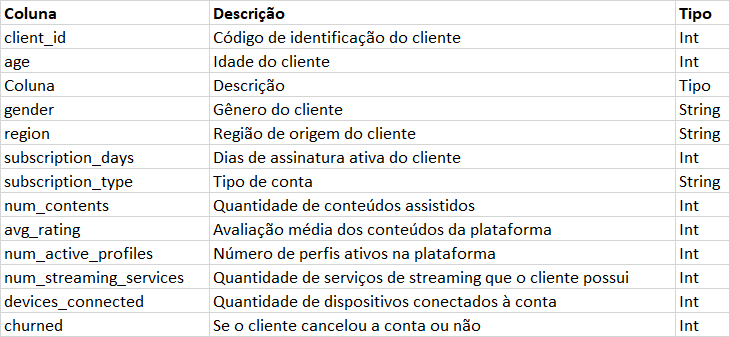

In [1095]:
#upload do arquivo
churn = pd.read_csv("/content/streaming_data.csv")
#apresentação dos dados
churn.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


# Data Understanding

In [1096]:
#descrição dos dados
churn.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


In [1097]:
#procurar valores nulos nos dados
valores_nulos_totais = churn.isnull().sum()
print("Valores nulos totais no DataFrame:")
print(valores_nulos_totais)

Valores nulos totais no DataFrame:
Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64


In [1098]:
#valores nulos de Num_streaming_services é muito grande
#não faz sentido ter valor 0, por isso a coluna vai ser retirada
churn.drop('Num_streaming_services', axis=1, inplace=True)

In [1099]:
#valores nulos das colunas Age, Gender e Subscription_type não podem ser 0 por isso vão ser dropados
churn.dropna(subset=['Age', 'Gender', 'Subscription_type'], inplace=True)

In [1100]:
#resto dos valores serão substituidos por 0
churn['Time_on_platform'].fillna(0, inplace=True)
churn['Devices_connected'].fillna(0, inplace=True)
churn['Avg_rating'].fillna(0, inplace=True)
churn['Churned'].fillna(0, inplace=True)

In [1101]:
#verificando a existencia ainda de valores nulos
valores_nulos_totais = churn.isnull().sum()
print("Valores nulos totais no DataFrame:")
print(valores_nulos_totais)

Valores nulos totais no DataFrame:
Age                    0
Gender                 0
Time_on_platform       0
Devices_connected      0
Subscription_type      0
Num_active_profiles    0
Avg_rating             0
Churned                0
User_id                0
dtype: int64


In [1102]:
#Informações dos dados
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36515 entries, 0 to 77883
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  36515 non-null  float64
 1   Gender               36515 non-null  object 
 2   Time_on_platform     36515 non-null  float64
 3   Devices_connected    36515 non-null  float64
 4   Subscription_type    36515 non-null  object 
 5   Num_active_profiles  36515 non-null  int64  
 6   Avg_rating           36515 non-null  float64
 7   Churned              36515 non-null  float64
 8   User_id              36515 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 2.8+ MB


In [1103]:
#Alterando os tipos das colunas
churn['Age'] = churn['Age'].astype(int)
churn['Devices_connected'] = churn['Devices_connected'].astype(int)
churn['Num_active_profiles'] = churn['Num_active_profiles'].astype(int)
churn['Avg_rating'] = churn['Avg_rating'].astype(int)
churn['Time_on_platform'] = churn['Time_on_platform'].astype(int)

In [1104]:
churn['Churned'] = churn['Churned'].map({0: 'Não', 1: 'Sim'})

In [1105]:
#Número de usarios churned
churn_agg = churn.groupby("Churned")['User_id'].count().reset_index()
churn_agg = pd.DataFrame(churn_agg)
churn_agg

,Churned,User_id
0,Não,29459
1,Sim,7056


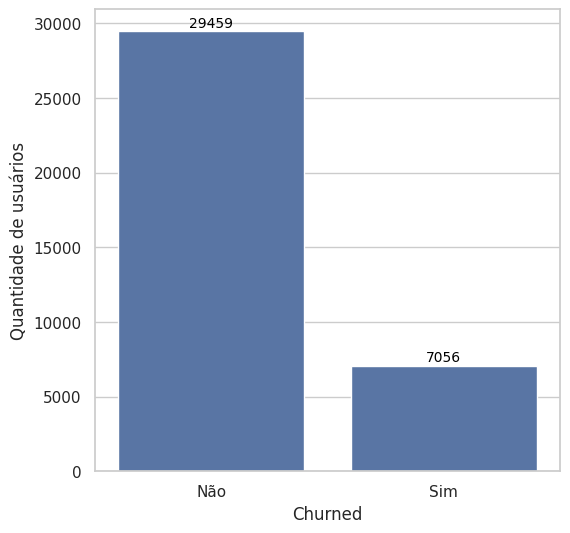

In [1106]:
#Grafico de usarios churned
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

ax = sns.barplot(data=churn_agg, x="Churned", y="User_id")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 6),
                textcoords='offset points')

plt.xlabel("Churned")
plt.ylabel("Quantidade de usuários")

plt.show()

In [1107]:
#Classificação por tipo assinatura
churn_agg = churn.groupby("Subscription_type")['User_id'].count().reset_index()
churn_agg = pd.DataFrame(churn_agg)
churn_agg

,Subscription_type,User_id
0,Basic,12134
1,Premium,12224
2,Standard,12157


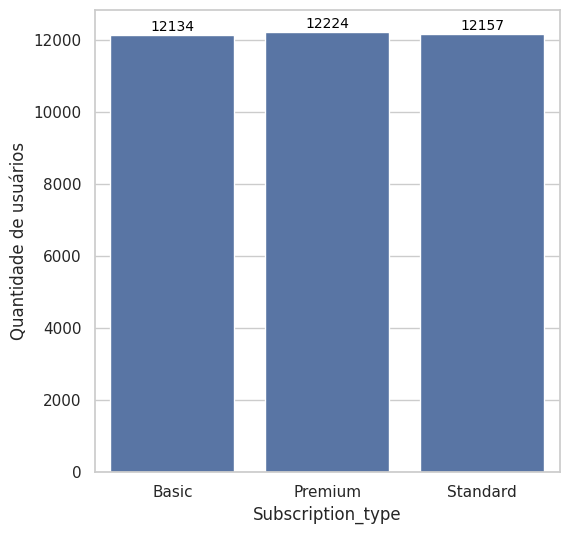

In [1108]:
#Grafico por tipo de assinatura
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

ax = sns.barplot(data=churn_agg, x="Subscription_type", y="User_id")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 6),
                textcoords='offset points')

plt.xlabel("Subscription_type")
plt.ylabel("Quantidade de usuários")

plt.show()

In [1109]:
#Classificaçao por assinatura
churn_agg_gender = churn.groupby("Gender")['User_id'].count().reset_index()
churn_agg_gender = pd.DataFrame(churn_agg_gender)
churn_agg_gender

,Gender,User_id
0,Female,18149
1,Male,18366


# Preparação para modelagens

In [1110]:
churn.dtypes

Age                     int64
Gender                 object
Time_on_platform        int64
Devices_connected       int64
Subscription_type      object
Num_active_profiles     int64
Avg_rating              int64
Churned                object
User_id                object
dtype: object

In [1111]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(churn.Churned)
churn.Churned = le.transform(churn.Churned)

In [1112]:
X = churn.drop(['User_id', 'Churned'], axis=1)

y = churn[['Churned']]

In [1113]:
X = pd.get_dummies(X)

In [1114]:
# Import the necessary sklearn method
from sklearn.preprocessing import MinMaxScaler
# Instantiate a Min-Max scaling object
mm = MinMaxScaler()
# Fit and transform our feature data into a pandas dataframe
X = pd.DataFrame(mm.fit_transform(X))

In [1115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [1116]:
y_train = y_train['Churned'].to_numpy().ravel()
y_test = y_test['Churned'].to_numpy().ravel()

# Regressão Logística

In [1117]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
lr = model.fit(X_train, y_train)

In [1118]:
lr.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [1119]:
X_test.assign(churn = y_test).assign(label = lr.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,churn,label
1117,0.431373,0.354493,1.0,0.75,0.6,0.0,1.0,0.0,1.0,0.0,0,0
1317,0.862745,0.794497,0.2,1.00,0.4,0.0,1.0,0.0,0.0,1.0,0,0
3503,0.921569,0.276630,0.8,0.50,0.8,1.0,0.0,0.0,0.0,1.0,0,0
22340,0.549020,0.983788,0.0,0.75,0.6,0.0,1.0,0.0,0.0,1.0,0,0
4383,0.764706,0.510789,0.4,1.00,0.4,0.0,1.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9813,0.941176,0.860258,0.8,0.25,0.6,1.0,0.0,0.0,0.0,1.0,1,0
18618,0.313725,0.000000,0.2,0.50,0.6,0.0,1.0,0.0,0.0,1.0,0,0
9186,0.764706,0.629524,1.0,0.50,0.2,0.0,1.0,0.0,1.0,0.0,0,0
6990,0.647059,0.000000,0.8,0.25,0.6,0.0,1.0,0.0,0.0,1.0,0,0


--------------------Previsão-----------------



Text(0.5, 1.0, 'Projetado')

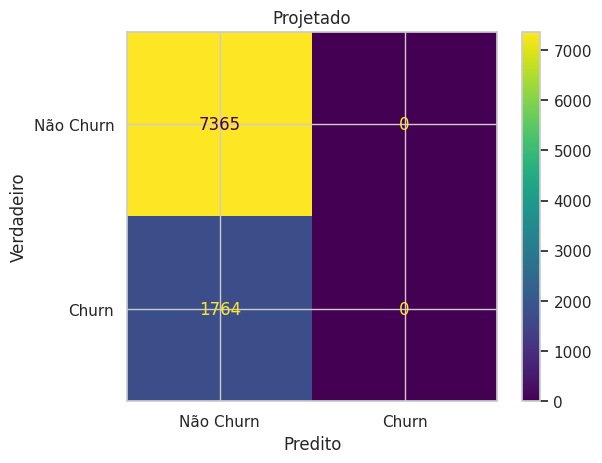

In [1120]:
print('--------------------Previsão-----------------\n')
y_pred = lr.predict(X_test)

#Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn', 'Churn']).plot()
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Projetado')

In [1121]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"Acurácia (Treino): {accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.8067625794201416
Acurácia (Teste): 0.8067696352283931
Acurácia Balanceada (Treino): 0.5
Acurácia Balanceada (Teste): 0.5
Precision (Treino): 0.0
Precision (Teste): 0.0
Recall (Treino): 0.0
Recall (Teste): 0.0
F1-Score (Treino): 0.0
F1-Score (Teste): 0.0
ROCAUC (Treino): 0.5124359390417402
ROCAUC (Teste): 0.49988034815646104


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest


In [1122]:
from sklearn.ensemble import RandomForestClassifier

rf =  RandomForestClassifier()

In [1123]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [1124]:
rf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [1125]:
X_test.assign(churn = y_test).assign(label = rf.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,churn,label
1117,0.431373,0.354493,1.0,0.75,0.6,0.0,1.0,0.0,1.0,0.0,0,0
1317,0.862745,0.794497,0.2,1.00,0.4,0.0,1.0,0.0,0.0,1.0,0,0
3503,0.921569,0.276630,0.8,0.50,0.8,1.0,0.0,0.0,0.0,1.0,0,0
22340,0.549020,0.983788,0.0,0.75,0.6,0.0,1.0,0.0,0.0,1.0,0,0
4383,0.764706,0.510789,0.4,1.00,0.4,0.0,1.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9813,0.941176,0.860258,0.8,0.25,0.6,1.0,0.0,0.0,0.0,1.0,1,1
18618,0.313725,0.000000,0.2,0.50,0.6,0.0,1.0,0.0,0.0,1.0,0,0
9186,0.764706,0.629524,1.0,0.50,0.2,0.0,1.0,0.0,1.0,0.0,0,0
6990,0.647059,0.000000,0.8,0.25,0.6,0.0,1.0,0.0,0.0,1.0,0,0


--------------------Previsão-----------------



Text(0.5, 1.0, 'Projetado')

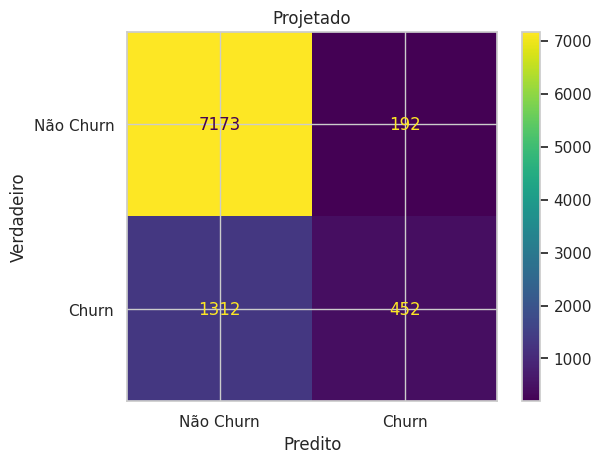

In [1126]:
print('--------------------Previsão-----------------\n')
y_pred = rf.predict(X_test)

#Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn', 'Churn']).plot()
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Projetado')

In [1127]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"Acurácia (Treino): {accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.992770028481706
Acurácia (Teste): 0.8352503012378135
Acurácia Balanceada (Treino): 0.9847413966340889
Acurácia Balanceada (Teste): 0.6150832906142769
Precision (Treino): 0.9907514450867052
Precision (Teste): 0.7018633540372671
Recall (Treino): 0.971655328798186
Recall (Teste): 0.2562358276643991
F1-Score (Treino): 0.9811104751001717
F1-Score (Teste): 0.37541528239202665
ROCAUC (Treino): 0.9996552984872373
ROCAUC (Teste): 0.6785860915988935


# Tunning

In [790]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'n_estimators': [100, 300, 500]}

grid_search = GridSearchCV(rf, parameters, scoring='accuracy', cv=5, n_jobs=-1)

In [791]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [792]:
dict = grid_search.best_estimator_.get_params()

In [793]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [1026]:
from sklearn.ensemble import RandomForestClassifier

rf_tunned =  RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0,
                                     class_weight = None, criterion= 'gini',
                                     max_depth = 1, max_features= 'sqrt',
                                     max_leaf_nodes = None,
                                     max_samples = None,
                                     min_impurity_decrease = 0.0,
                                     min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     min_weight_fraction_leaf = 0.0,
                                     n_estimators = 100, n_jobs = None,
                                     oob_score = False, random_state = None,
                                     verbose = 0, warm_start = False)
rf_tunned

RandomForestClassifier(max_depth=10)

In [1027]:
rf_tunned.fit(X_train, y_train)

<ipython-input-1027-23d38da6abb7>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_tunned.fit(X_train, y_train)


RandomForestClassifier(max_depth=10)

In [1028]:
rf_tunned.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [1029]:
X_test.assign(churn = y_test).assign(label = rf_tunned.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,churn,label
6159,0.607843,0.278114,0.4,0.00,0.2,1.0,0.0,0.0,1.0,0.0,NaN,0
956,0.725490,0.000000,0.6,0.00,0.4,1.0,0.0,0.0,0.0,1.0,NaN,0
24162,0.686275,0.000000,0.4,0.25,0.2,1.0,0.0,0.0,0.0,1.0,NaN,0
14821,0.941176,0.662062,1.0,0.25,0.6,1.0,0.0,1.0,0.0,0.0,NaN,0
12929,0.450980,0.427789,1.0,0.25,0.6,1.0,0.0,1.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9802,0.725490,0.551204,0.0,0.00,0.4,1.0,0.0,1.0,0.0,0.0,NaN,0
8386,0.862745,0.492636,0.2,0.00,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0
16693,0.411765,0.541957,0.8,0.00,0.6,1.0,0.0,0.0,0.0,1.0,NaN,0
2505,0.803922,0.671195,0.0,0.50,0.4,1.0,0.0,0.0,0.0,1.0,NaN,0


In [1030]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"Acurácia (Treino): {accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf.predict(X_train), pos_label='Sim')}")
print(f"Precision (Teste): {precision_score(y_test, rf.predict(X_test), pos_label='Sim')}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf.predict(X_train), pos_label='Sim')}")
print(f"Recall (Teste): {recall_score(y_test, rf.predict(X_test), pos_label='Sim')}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf.predict(X_train), pos_label='Sim')}")
print(f"F1-Score (Teste): {f1_score(y_test, rf.predict(X_test), pos_label='Sim')}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.9929891185277149
Acurácia (Teste): 0.832730857706211
Acurácia Balanceada (Treino): 0.9852364383992234
Acurácia Balanceada (Teste): 0.6126596191769308


ValueError: pos_label=Sim is not a valid label. It should be one of [0, 1]